### Hypothesis
Is economic factors such as GDP can have any impact on mortality rate in a group of countries

### read the packages

In [102]:
# General Libraries
import numpy as np
import pandas as pd
import yaml
import re
import folium
import panel as pn
from numpy import log10
pn.extension()

# Plotting Libraries
from bokeh.io import output_notebook, output_file
from bokeh.plotting import ColumnDataSource
from bokeh.plotting import figure, show, row, reset_output
from bokeh.layouts import layout
from bokeh.transform import factor_cmap
from bokeh.models import Band, Legend, CustomJS, Whisker
from bokeh.models import Div, RangeSlider,  MultiChoice
from bokeh.models import ColumnDataSource, FactorRange
import matplotlib.pyplot as plt

# statistical imports
import statsmodels.api as sm
from scipy.stats import sem
from scipy.stats import norm, gamma
from scipy.stats import iqr
from scipy.stats import wilcoxon

### get the confige dictionary

In [103]:
#inspired by https://fennaf.gitbook.io/bfvm22prog1/data-processing/configuration-files/yaml

def configReader():
    """
    explanation: This function open config,yaml file 
    and fetch the gonfigue file information
    input: ...
    output: configue file
    """
    with open("config.yaml", "r") as inputFile:
        config = yaml.safe_load(inputFile)
    return config

### Read the Data

In [104]:
def making_dataframes(config):

    """
    input: configue file(consist of file names)
    explanation: This function open data sources and store them in three 
                 different data frames. Also, it contains the name of World 
                 map json file for maps.  
    output: 1- GDP df
            2- Mortality df
            3- Class df
            4- World Map file Name
    """

    worldMapName, GDPName, mortalityName, countryClassName = config.values()
    GDPDf = pd.read_csv(GDPName, skiprows=4, usecols=np.arange(66))
    mortalityDf = pd.read_csv(mortalityName, skiprows=6, index_col=False)
    countryClassDf = pd.read_csv(countryClassName, usecols=np.arange(5))
    return GDPDf, mortalityDf, countryClassDf, worldMapName

GDPDf, mortalityDf, countryClassDf, worldMapName = making_dataframes(configReader())
mortalityDf.head()

,Region Code,Region Name,Country Code,Country Name,Year,Sex,Age group code,Age Group,Number,Percentage of cause-specific deaths out of total deaths,Age-standardized death rate per 100 000 standard population,Death rate per 100 000 population
0,EU,Europe,ALB,Albania,1987,All,Age_all,[All],2994.0,17.280388,92.612964,97.331036
1,EU,Europe,ALB,Albania,1987,All,Age00,[0],1421.0,57.787719,NaN,1763.027295
2,EU,Europe,ALB,Albania,1987,All,Age01_04,[1-4],656.0,53.117409,NaN,229.370629
3,EU,Europe,ALB,Albania,1987,All,Age05_09,[5-9],36.0,17.821782,NaN,10.807565
4,EU,Europe,ALB,Albania,1987,All,Age10_14,[10-14],21.0,15.555556,NaN,6.643467


### Data Inspecting

inspect the data sets to find more information about them.

In [105]:
def inspecting_data(GDPDf, mortalityDf, countryClassDf):

    """
    input: 1- GDP df
           2- Mortality df
           3- Class df
    explanation: This function inspect three data sets and find some 
                 properties of them.  
    output: some dataframes' properties are printed.
    """
    
    # find the number of countries that are not catagorized in classes
    nullClass = countryClassDf['IncomeGroup'].isnull().sum()
    print(f'The number of countries that are not catagorized in classes is {nullClass}')

    # find the number of countries per class
    incomeClass = pd.DataFrame(countryClassDf.groupby('IncomeGroup'))

    for counter in incomeClass.index:
        print(f'class {incomeClass[0].loc[counter]} has {len(incomeClass[1].loc[counter])} members')

    #find the number of missing data for each country and the number of countries with fewest one
    nullFinder = GDPDf.set_index('Country Name').isnull().sum(axis=1)
    print(f'\n{len(nullFinder[nullFinder < 5])} countries have les than five missing data')
    print(f'{len(nullFinder[(nullFinder > 5) & (nullFinder < 20)])} countries have more than five and less than twenty missing data')
    print(f'{nullFinder.head()}\n')

    #find the number of countries in mortality data frame 
    countryNumber = len(mortalityDf.groupby('Country Code'))
    print(f'The number of country in WHO data base is {countryNumber}')

    #find how many countries have WHO data base after 2018
    mortalityAfter2018 = mortalityDf[mortalityDf['Year'] >= 2018] 
    countryNumber2018 = len(mortalityAfter2018.groupby('Country Code'))
    print(f'The number of country in WHO data base that has data after 2018 is {countryNumber2018}')

inspecting_data(GDPDf, mortalityDf, countryClassDf)

The number of countries that are not catagorized in classes is 49
class High income has 80 members
class Low income has 28 members
class Lower middle income has 54 members
class Upper middle income has 54 members

131 countries have les than five missing data
38 countries have more than five and less than twenty missing data
Country Name
Aruba                          26
Africa Eastern and Southern     0
Afghanistan                    20
Africa Western and Central      0
Angola                         20
dtype: int64

The number of country in WHO data base is 114
The number of country in WHO data base that has data after 2018 is 76


### Data Wrangling

First of all, the number of countries in data bases are different so it is necessary to make a new data frame based on all of them.

In [106]:
def making_tidy_dataframe(GDPDf, mortalityDf, countryClassDf):

    """
    input: 1- GDP df
           2- Mortality df
           3- Class df
    explanation: This function merge three data frames into one tidy 
                 general datafram.  
    output: GDPMortalityClass (tidy general dataframe)
    """
    
    # make a new data frame by merging all the data frames
    mortalityCountryDf = pd.DataFrame(mortalityDf.groupby('Country Code'))
    mortalityCountryDf.columns = ['Country Code', 'Mortality']

    GDPClass = GDPDf.merge(countryClassDf, right_on='Country Code', 
                           left_on='Country Code', how='inner')
    GDPMortalityClass = GDPClass.merge(mortalityCountryDf, right_on='Country Code', 
                           left_on='Country Code', how='inner')
    
    GDPMortalityClass = GDPMortalityClass.drop("TableName", axis='columns')
    
    return GDPMortalityClass

GDPMortalityClass = making_tidy_dataframe(GDPDf, mortalityDf, countryClassDf)
GDPMortalityClass.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,Region,IncomeGroup,SpecialNotes,Mortality
0,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.186120e+10,1.301969e+10,1.515643e+10,1.540183e+10,1.513187e+10,1.825579e+10,Europe & Central Asia,Upper middle income,NaN,Region Code Region Name Country Code Coun...
1,Argentina,ARG,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,2.445060e+10,1.827212e+10,2.560525e+10,2.834471e+10,...,5.575314e+11,6.436287e+11,5.248197e+11,4.477546e+11,3.855402e+11,4.872273e+11,Latin America & Caribbean,Upper middle income,The World Bank systematically assesses the app...,Region Code Region Name Co...
2,Armenia,ARM,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.054614e+10,1.152746e+10,1.245794e+10,1.361929e+10,1.264170e+10,1.386141e+10,Europe & Central Asia,Upper middle income,NaN,Region Code Region Name Country Code Coun...
3,Antigua and Barbuda,ATG,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.436585e+09,1.467978e+09,1.605944e+09,1.687533e+09,1.370281e+09,1.471126e+09,Latin America & Caribbean,High income,NaN,Region Code Region N...
4,Australia,AUS,GDP (current US$),NY.GDP.MKTP.CD,1.860567e+10,1.968194e+10,1.992160e+10,2.153881e+10,2.379998e+10,2.597491e+10,...,1.206535e+12,1.326516e+12,1.428289e+12,1.392228e+12,1.326901e+12,1.552667e+12,East Asia & Pacific,High income,The reporting period for national accounts dat...,Region Code Region Name Country Code Cou...


In [107]:
def inspecting_tidy_dataframe(GDPMortalityClass):

    """
    input: 1- GDPMortalityClass (tidy general dataframe)
    explanation: This function inspect the general dataframe and grouped 
    it based on income level.
    output: countryIncomeGroup (grouped dataframe on income level)
    """ 

    # investigate 'info' information of the general data
    print(f'{GDPMortalityClass.info()}\n')

    # find how many countruies are there per each class in the final dataframe
    countryIncomeGroup = pd.DataFrame(GDPMortalityClass.groupby('IncomeGroup'))
    for counter in countryIncomeGroup.index:
        print(f'class {countryIncomeGroup[0].loc[counter]} has {len(countryIncomeGroup[1].loc[counter])} members')

    # Return the grouped data based on INCOME LEVEL
    return countryIncomeGroup

countryIncomeGroup = inspecting_tidy_dataframe(GDPMortalityClass)        

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 0 to 108
Data columns (total 70 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    109 non-null    object 
 1   Country Code    109 non-null    object 
 2   Indicator Name  109 non-null    object 
 3   Indicator Code  109 non-null    object 
 4   1960            57 non-null     float64
 5   1961            57 non-null     float64
 6   1962            58 non-null     float64
 7   1963            58 non-null     float64
 8   1964            58 non-null     float64
 9   1965            63 non-null     float64
 10  1966            64 non-null     float64
 11  1967            64 non-null     float64
 12  1968            65 non-null     float64
 13  1969            65 non-null     float64
 14  1970            65 non-null     float64
 15  1971            66 non-null     float64
 16  1972            66 non-null     float64
 17  1973            66 non-null     flo

Because countries are distributed assymmetrically in the groups I think of three solusions for this:

1- choose just one country from each catagory.

2- merging two low classes and two high classes and make an avarage with error bars

3- using another data set that contains more countries. 

however, the first way cannot be a good method as one country cannot provide any credible statistical information. The third way needs much more time and effort to find a credible data set. Consequently, the best way will be the second one.


Second way:

In [108]:
def making_two_main_dataframes(countryIncomeGroup):

    """
    input: 1- countryIncomeGroup (tidy general dataframe based on income group)
    explanation: This function makes two dataframe based on two lower and upper classes.
    output: 1- lowerClassDf
            2- upperClassDf
    """ 

    # devide the data frame into to distict data frame one for lower class countries another for upper ones
    lowerClassDf = pd.concat([countryIncomeGroup[1].loc[1], 
                          countryIncomeGroup[1].loc[2]], ignore_index=True)
    upperClassDf = pd.concat([countryIncomeGroup[1].loc[0], 
                          countryIncomeGroup[1].loc[3]], ignore_index=True)

    # find the number of null data in the data set for each catagory
    nullFinderLower = lowerClassDf.set_index('Country Name').isnull().sum(axis=1)
    nullFinderUpper = upperClassDf.set_index('Country Name').isnull().sum(axis=1)

    # Print the number null values per class (catagory)
    print(f'The number of missing GDP data per country in lower class: \n {nullFinderLower.head()}')
    print(f'The number of missing GDP data per country in upper class: \n {nullFinderUpper.head()}')
    return lowerClassDf, upperClassDf

lowerClassDf, upperClassDf = making_two_main_dataframes(countryIncomeGroup)

The number of missing GDP data per country in lower class: 
 Country Name
Syrian Arab Republic     1
Cabo Verde              21
Egypt, Arab Rep.         5
Iran, Islamic Rep.       2
Kyrgyz Republic         31
dtype: int64
The number of missing GDP data per country in upper class: 
 Country Name
Antigua and Barbuda    18
Australia               0
Austria                 0
Belgium                 0
Bahrain                21
dtype: int64


In [109]:
def making_gdp_dataframe(lowerClassDf, upperClassDf):

    """
    input: 1- lowerClassDf
           2- upperClassDf
    explanation: This function makes two GDP dataframes for lower and upper 
                 classes for further investigation.
    output: 1- lowerClassGdpDf
            2- upperClassGdpDf
    """ 

    # prepare the GDP data for sketching
    # choose the required columns for sketching GDP
    lowerClassGdpDf = lowerClassDf.set_index('Country Code').iloc[:,3 : 65].transpose()
    upperClassGdpDf = upperClassDf.set_index('Country Code').iloc[:,3 : 65].transpose()

    # GDP data chanches linearly so use linear interplation to fill all null data points
    lowerClassGdpDf = lowerClassGdpDf.interpolate(method='linear').astype('f')
    upperClassGdpDf = upperClassGdpDf.interpolate(method='linear').astype('f')

    return lowerClassGdpDf, upperClassGdpDf

lowerClassGdpDf, upperClassGdpDf = making_gdp_dataframe(lowerClassDf, upperClassDf)
lowerClassGdpDf.head()

Country Code,SYR,CPV,EGY,IRN,KGZ,LBN,LKA,MNG,NIC,PHL,SLV,STP,TJK,UKR,UZB
1960,8.577044e+08,NaN,NaN,4.199134e+09,NaN,NaN,1.409874e+09,NaN,223854672.0,7.515887e+09,NaN,NaN,NaN,NaN,NaN
1961,9.452450e+08,NaN,NaN,4.426949e+09,NaN,NaN,1.444328e+09,NaN,240524720.0,8.171186e+09,NaN,NaN,NaN,NaN,NaN
1962,1.110566e+09,NaN,NaN,4.693566e+09,NaN,NaN,1.434156e+09,NaN,265291584.0,4.954529e+09,NaN,NaN,NaN,NaN,NaN
1963,1.200447e+09,NaN,NaN,4.928628e+09,NaN,NaN,1.240672e+09,NaN,292916256.0,5.505056e+09,NaN,NaN,NaN,NaN,NaN
1964,1.339494e+09,NaN,NaN,5.379846e+09,NaN,NaN,1.309748e+09,NaN,341973760.0,5.953767e+09,NaN,NaN,NaN,NaN,NaN


I have tried to extrapolate the data. The best method that we can use here is a first order polynomial function since the data trend changes linearly. I used a linear spline as the main method and the Lagrange method as the core method.

In [110]:
def lagrange(x, xdata, ydata):

    """
    y = lagrange(x, xdata, ydata).
    Lagrange's interpolation method that interpolates a
    polynomial through data {xdata,ydata}, evaluated at x.
    """
    
    n = len(xdata)
    if len(ydata) != n:
        raise ValueError('Data of unequal length')
    y = 0

    # calculate each term
    for i in range(n):
        #l_i = 1
        cardinal = 1 

        # calculate the cardinal
        for j in range(n):
            if i != j:
                cardinal *= (x - xdata[j]) / (xdata[i] - xdata[j])
        y += cardinal * ydata[i]
    
    return y

In [111]:
def linear_spline(x, xdata, ydata):

    """
    y = linear_spline(x, xdata, ydata).
    linear spline interpolation method that interpolates
    a piecewise 1st-degree polynomial through data
    {xdata,ydata}, evaluated at x. Inside the mentioned method, 
    Lagrange interpolation is used.
    """
    
    n = len(xdata)
    if len(ydata) != n:
        raise ValueError('Data of unequal length')
    
    # make data order
    xdata, ydata = zip(*sorted(zip(xdata, ydata)))

    i = 0
    for counter, x_i in enumerate(xdata):
        if x < x_i:
            i = counter
            break

        else:
            i = counter + 1

    if  i == 0:
        i = 1
    if i == n:
        i = n-1
    
    left = lagrange(x, xdata[max(i-1, 0):min(i, n)], ydata[max(i-1, 0):min(i, n)])
    right = lagrange(x, xdata[max(i, 0):min(i+1, n)], ydata[max(i, 0):min(i+1, n)])

    y = ((x - xdata[i-1]) * right - (x - xdata[i]) * left) / (xdata[i]-xdata[i-1])

    return y

In [112]:
def extrapolating_dataframe(df):

    """
    input: 1- df (lowerClassGdpDf, upperClassGdpDf)
    explanation: This function extrapolates a dataframe by using linear spline 
    method. 
    output: newDf (extrapolated df)
    """ 

    # to extrapolate we have unfortunately no choice  other than using a for loop!!
    newDf = df.copy()

    for column in newDf.columns:

        ydata = newDf[column].dropna()
        xdata = ydata.index.astype('f').values
        xs = newDf.index.astype('f').values

        newDf[column] = [linear_spline(x, xdata, ydata) for x in xs]

    return newDf
lowerExtrapolatedDf = extrapolating_dataframe(lowerClassGdpDf)
lowerExtrapolatedDf.head()

Country Code,SYR,CPV,EGY,IRN,KGZ,LBN,LKA,MNG,NIC,PHL,SLV,STP,TJK,UKR,UZB
1960,8.577044e+08,197822240.0,3.301976e+09,4.199134e+09,5.841671e+09,1.998870e+10,1.409874e+09,-2.778258e+09,223854672.0,7.515887e+09,618720000.0,-302073056.0,4.102483e+10,-2.225396e+11,3.850188e+09
1961,9.452450e+08,195043472.0,3.631314e+09,4.426949e+09,5.736116e+09,1.939316e+10,1.444328e+09,-2.535955e+09,240524720.0,8.171186e+09,670520000.0,-292852952.0,3.974506e+10,-2.119237e+11,4.167202e+09
1962,1.110566e+09,192264704.0,3.960652e+09,4.693566e+09,5.630560e+09,1.879762e+10,1.434156e+09,-2.293652e+09,265291584.0,4.954529e+09,722320000.0,-283632848.0,3.846530e+10,-2.013079e+11,4.484216e+09
1963,1.200447e+09,189485936.0,4.289991e+09,4.928628e+09,5.525004e+09,1.820208e+10,1.240672e+09,-2.051350e+09,292916256.0,5.505056e+09,774120000.0,-274412744.0,3.718553e+10,-1.906921e+11,4.801230e+09
1964,1.339494e+09,186707168.0,4.619329e+09,5.379846e+09,5.419449e+09,1.760654e+10,1.309748e+09,-1.809047e+09,341973760.0,5.953767e+09,825920000.0,-265192640.0,3.590576e+10,-1.800763e+11,5.118244e+09


The reason that I choose linear spline is that GDP data should be extrapolated by using interpolation methods and not curve fitting since the line should pass through all the points. Also, linear spline is chosen because the line between the datapoints should be linear and without any curvature. 

In [113]:
def plotting_extrapolated_line(ExtrapolatedDf, normalDf, countryCode):

    """
    input: 1- ExtrapolatedDf
           2- normalDf (dataframe without extrapolation)
           3- country code
    explanation: This function plot the extrapolated line and non-extrapolated 
                 scatter data to present the differences.
    """

    fig = figure(title='extrapolated data vs. normal data (Cabo Verde)', y_axis_type='log', 
             background_fill_color='#f0f2f4',border_fill_color='#f0f2f4', x_axis_label='time', 
             y_axis_label='GDP',plot_width=900, plot_height=400)

    fig.line(ExtrapolatedDf.index, ExtrapolatedDf[countryCode], line_width=2, color='red', 
             legend_label='extrapolated data')
    
    fig.scatter(normalDf.index, normalDf[countryCode], color='black', legend_label='normal data')
    fig.legend.location = "top_left"

    output_notebook()
    show(fig)

# Plot Cabo Verde data set as an example
plotting_extrapolated_line(lowerExtrapolatedDf, lowerClassGdpDf, 'CPV')

Loading BokehJS ...

Here (country = 'Cabo Verde') is chosen for explaining the reasoning behid NOT using extrapolation. 
However, this trend cannot be a correct trend for GDP data since we cannot infer that the GDP of the chosen country decreased from 1960 to 1980. Consequently, it is concluded that there should be more information about the condition of these countries to extrapolate their GDP and also death rates. As a result, interpolation techniques are not used for analyzing these datasets.

### Presenting the Data 
In this part GDP dataframes (lower class and upper class) and also Mortality dataframes (lower class and upper class) are presented in different plots. 

First, some general polot functions will be introduce.
#### Assistant functions
Calculating mean values

In [114]:
def adding_mean_bonds(df, ax, dataType, groupPar='Year', mortalityPar='Number'):

    """
    Input= 1- df: dataframe
           2- ax: the axis that parameters are calculated (column/row)
           3- dataType: GPD/Mortality
           4- groupPar: the parameter that is used in groupby (Year/Country Code) 
           5- mortalityPar: parameters from mortality df.('Death rate per 100 000 population', 
           'Number', 'Percentage of cause-specific deaths out of total deaths')
    Explanation= this program calculate mean calue and erro bond for each dataframe.
    Output= a new data frame contains mean and upper and lower bonds columns.
    """

    df_new = pd.DataFrame()

    # Calculate mean upper and lower bonds for GDP dataframe
    if dataType =='GDP':
        mean = df.mean(axis=ax)
        sem = df.sem(axis=ax)
        upperBond = mean + 1.96 * sem
        lowerBond = mean - 1.96 * sem

        df_new = df_new.assign(mean=mean, upper_bond=upperBond,
                                lower_bond=lowerBond)     
        return df_new        

    # Calculate mean upper and lower bonds for Mortality dataframe    
    elif dataType == 'Mortality':
        mean = df.groupby(groupPar).mean()
        sem = df.groupby(groupPar).sem()
        upperBond = mean + 1.96 * sem
        lowerBond = mean - 1.96 * sem

        df_new = df_new.assign(mean=mean[mortalityPar], upper_bond=upperBond[mortalityPar],
                                lower_bond=lowerBond[mortalityPar])   
  
        return df_new  

cleaning mortality dataframe for sketching plots

In [115]:
def making_mortaliry_dataframe(df, sex, age, plotType, countryList='IRN'):

    """
    Input= 1- df: dataframe
           2- sex: gender type
           3- age: age range
    Explanation= this program making a new df to fit in the line plot.
    Output= df.
    """

    df_new = pd.DataFrame()
    dfAssistant = df.iloc[:,[0,1,-1]]['Mortality']

    if plotType == 'line':
    
        for counter in range(len(dfAssistant)):
        
            countryMortalityDf = dfAssistant[counter]
            df1 = countryMortalityDf[(countryMortalityDf['Sex'] == sex) & \
                        (countryMortalityDf['Age group code'] == age)].interpolate(method='linear').reset_index()
            df_new = pd.concat([df_new,df1], ignore_index=True)

        return df_new

    elif plotType == 'bar':

        for counter in range(len(dfAssistant)):

            if dfAssistant[counter]['Country Code'].unique() in countryList:
                countryMortalityDf = dfAssistant[counter]
                df_new = pd.concat([df_new,countryMortalityDf], ignore_index=True)
                
        return df_new

making final dataframe for plots

In [116]:
def making_mean_df_mortality(groupPar, sex, age, mortalityPar): 

    """
    Input= 1- groupPar: the parameter that is used in groupby (Year/Country Code) 
           2- sex: gender type
           3- age: age range
           4- Color: color of each class is different
           5- mortalityPar: parameters from mortality df.('Death rate per 100 000 population', 
           'Number', 'Percentage of cause-specific deaths out of total deaths')
    Explanation= this program making two final df for two classes for plot.
    Output= 1- lowerMeanDf: mean mortality value (lower class)
            2- upperMeanDf: mean mortality value (upper class)
    """ 

    lowerMortalityDf = making_mortaliry_dataframe(lowerClassDf, sex, age, 'line')
    upperMortalityDf = making_mortaliry_dataframe(upperClassDf, sex, age, 'line')
 
    lowerMeanDf = adding_mean_bonds(lowerMortalityDf, 1, 'Mortality', groupPar=groupPar,
                                 mortalityPar=mortalityPar)
    upperMeanDf = adding_mean_bonds(upperMortalityDf, 1, 'Mortality', groupPar=groupPar,
                                 mortalityPar=mortalityPar)
    return lowerMeanDf, upperMeanDf

Make the infrastructure of the plots

In [117]:
def making_plot(dataType, plotType, xRange, text):

   """
   Input= 1- dataType: GPD/Mortality
          2- plotType (line, bar)
          3- xRange (range of x coordination)
   Explanation= this program make a new plot.
   Output= new plot.
   """

   # make the plot for line charts
   if plotType == 'line':
      
      p = figure(title=f'{dataType}- {text}', y_axis_type='log', 
                 background_fill_color='#f0f2f4', border_fill_color='#f0f2f4', x_axis_label='year', 
                 x_range=(xRange[0], xRange[-1]), y_axis_label=f'{dataType}',plot_width=1100,
                plot_height=600)
      
      p.add_layout(Legend(), 'right')

   # make the plot for bar charts      
   elif plotType == 'bar':

      p = figure(title=f'{dataType}- {text}', background_fill_color='#f0f2f4', 
                 border_fill_color='#f0f2f4', x_axis_label='country', x_range=FactorRange(*xRange), 
                 y_axis_label=f'{dataType}',plot_width=1100, plot_height=600)
      
      p.add_layout(Legend(), 'right')  

   return p


#### Widgit Functions

DIV Widget

In [118]:
def making_div(text):

    """
    Input= 1- text
    Explanation= this funtion make a comment for a plot (div widgit)
                 in Bokeh style.
    Output= rangeSlider
    """  
    
    # Div
    div = Div(
        text=text,
        width=1100,
        height=30
        )
    return div

Rabge Slider Widget

In [119]:
def range_slider(p, startDate, endDate, step):

    """
    Input= 1- p: plot
    Explanation= this program makes an interactive range slider widgit
    for a difinite duration of time.
    Output= rangeSlider
    """

    # Make range slider
    rangeSlider = RangeSlider(
    title='time duration range',
    start=startDate,
    end=endDate,
    step=step,
    value=(p.x_range.start, p.x_range.end),  
    )

    # Connect range slider to the plot
    rangeSlider.js_link('value', p.x_range, 'start', attr_selector=0)
    rangeSlider.js_link('value', p.x_range, 'end', attr_selector=1)

    return rangeSlider

MultiChoice Widget using Bokeh

In [120]:
def making_multi_choice_bokeh_style(nameDict, df, className):

    """
    inspired by: https://stackoverflow.com/questions/70808303/filtering-data-
                 source-for-bokeh-plot-using-multichoice-and-customjs
    Input= 1- nameDict (line chart dictionary)
           2- df (dataframe)
           3- className (lower, upper)
    Explanation= this function makes a multichoice widgit based on Bokeh library.
    Output= make a multi choice widgit
    """

    # make a multichoice
    initialValue = [df.columns[0]]   
    option = list(df.columns)
    multiChoice = MultiChoice(value=initialValue, options=option, 
                              title=f'{className} Level Countries:')

    # impose the initial conditions
    for i in range(len(option)):
        if nameDict['label'][i] in initialValue:
            nameDict['name'][i].visible = True;
            nameDict['legend'][i].visible = True;
        else:
            nameDict['name'][i].visible = False;
            nameDict['legend'][i].visible = False;   
        
    callback = CustomJS(args=dict(nameDict=nameDict, multiChoice=multiChoice), code="""
    var selectedCountries = multiChoice.value;
    var indexCheck = [];

    for (var i = 0; i < nameDict['name'].length; i++) {
        indexCheck[i]=selectedCountries.indexOf(nameDict['label'][i]);
            if ((indexCheck[i])>= 0) {
                nameDict['name'][i].visible = true;
                nameDict['legend'][i].visible = true;
                }
            else {
                nameDict['name'][i].visible = false;
                nameDict['legend'][i].visible = false;
            }
        }
    """)

    multiChoice.js_on_change('value', callback)

    return multiChoice

#### Line Plot Functions
making line band

In [121]:
def plotting_line_band(df, p, legendLabel, lineColor, fillColor, edgeColor):

    """
    Input= 1- df: dataframe
           2- p: plot
           3- legendLabel: legend Label
           4- lineColor: color of each class is different
           5-fillColor: color of each class is different
           6- edgeColor: color of each class is different
    Explanation= this program plot the error band of parameters and add it to the plot.
    Output= updated plot.
    """

    lineGraphData = {
        'base' : df.index,
        'lower' : df['lower_bond'],
        'upper' : df['upper_bond'],
        'mean' : df['mean']
        }
    source = ColumnDataSource(data=lineGraphData)


    p.line(x='base', y='mean', legend_label=legendLabel, line_width=1, color=lineColor,
       source=source)

    band = Band(base='base', lower='lower', upper='upper', source=source, level='underlay',
                fill_alpha=0.7, line_width=1, fill_color=fillColor, line_color=edgeColor)

    p.add_layout(band)

    return p

making line charts for countries ion each class

In [122]:
def plotting_line_dictionary_for_multichoice(df, p, className):

    """
    inspired by: https://stackoverflow.com/questions/70808303/filtering-data-
                 source-for-bokeh-plot-using-multichoice-and-customjs
    Input= 1- df (dataframe)
           2- p (plot)
           3- className (lower, upper)
    Explanation= this function gets a dataframe of countries and make a dictionary 
                 of its countries line charts, legends, and labels.
    Output= nameDict (a dictionary of line plots, legends, and labels)
    """

    # Creat a dictionary for group og line charts
    nameDict={'name':[],'legend':[],'label':[]}
    legendLenght = len(p.legend.items)
    
    # Assign color that fits the group color(lower:Greaan, upper:red)
    if className == 'lower':
        color = ['#00802b', '#00cc44', '#4dff88', '#33cc33', '#29a329', '#66ff1a', '#bfff00',
         '#888844','#669900', '#99e600','#00cc99','#4d9900','#00994d','#99ff33', '#cccc00']

    else:
        color = ['#800000', '#ff0000', '#ff8080', '#993333', '#bf4040', '#df9f9f', '#660000',
         '#80002a','#b3003b', '#ff0055','#ff4d88','#ff99bb','#ffcccc','#e69900', '#ff0080',
         '#ff66b3', '#cc0000', '#ff1a1a', '#cc5200', '#ff6600', '#ff8533', '#ffa366',
         '#ff3300','#801a00', '#ff704d','#e60000','#ff6666','#ff9999','#ff0066', '#800033',
         '#ff4d94', '#602040', '#862d59', '#ac3973', '#cc6699', '#ffb31a', '#e6b3cc',
         '#73264d','#993366', '#c6538c','#d98cb3','#ffbb33','#ffaa00','#ffc34d', '#4d0026',
         '#b30059', '#ff3399', '#ffcce6', '#cc3399', '#7a1f5c', '#e085c2', '#4d004d',
         '#990099','#cc00cc', '#ff1aff','#ff80ff','#993300','#e64d00','#ff661a', '#ffbb99',
         '#802000', '#cc3300', '#ff4000', '#804000', '#ffb366', '#ff8c1a', '#b38f00',
         '#665200','#ffd633', '#800040','#660033','#e60073','#ff99cc','#ff99dd', '#b30077',
         '#391313', '#4d1919', '#602020', '#732626', '#862d2d', '#ac3939', '#d27979',
         '#d98c8c','#4d0000', '#990000','#b30000','#ff3333','#ff4d4d','#bf0000', '#4d1933',
         '#ecc6d9','#ff4dc4', '#ff66cc','#ff80d5','#ff1a8c']

    # Plot line charts based on each country
    for counter, country in enumerate(df.columns):
        lineGraphData = {
            'x' : df.index,
            'y' : list(log10(df[country]))
            }

        # Make the line chart for country
        source = ColumnDataSource(data=lineGraphData)
        plotCountry = p.line(x='x', y='y', source= source,
                                legend_label = country, line_width=2, line_color=color[counter])
            
       # Append the plot and its name to the dictionary
        nameDict['name'].append(plotCountry)
        nameDict['label'].append(country)

    # Append the legend to the dctionary
    for label in range(len(df.columns)):
        nameDict['legend'].append(p.legend.items[label+legendLenght])

    return nameDict

#### Bar Plot Functions

Calculating bar plot values

In [123]:
def making_bar_plot_values(df, choosenCountries, dataType):

    """
    Input= 1- df:dataframe
           2- choosenCountries: contains all the ON countries in the multichoice widgit
           3- dataType: GDP, Mortality
    Explanation= this program calculates all the plot's values.
    Output= 1- x
            2- y
            3- lower band
            4- upper band
    """    

    if dataType == 'GDP':
        dfMean = adding_mean_bonds(df, 0, dataType)
        x = [country for country in choosenCountries]
        y = [dfMean['mean'][country] for country in choosenCountries]
        lower = [dfMean['lower_bond'][country] for country in choosenCountries]
        upper = [dfMean['upper_bond'][country] for country in choosenCountries]


    elif dataType == 'Mortality':
        dfMean = adding_mean_bonds(df, 0, 'Mortality', 
                        ['Country Code','Sex'], 'Death rate per 100 000 population')
        dfMean.dropna()
        countries = list(df['Country Code'].unique())
        sexes =list(df['Sex'].unique())[:3]    

        x = [(country, sex) for country in countries for sex in sexes]
        y = list(dfMean['mean'].dropna())
        lower = list(dfMean['lower_bond'].dropna())
        upper = list(dfMean['upper_bond'].dropna())

    return x, y, lower, upper

Adding bar plot and wisker to the main plot

In [124]:
def plotting_bar_plot(p, x, y, lower, upper, fillColor, lineColor):
    
    """
    Input= 1- p: plot
           2- x
           3- y
           4- lower band
           5- upper band
           6- fill color (bar chart)
           7- line color (bar chart)
    Explanation= this program sketch and add bar chart and wisker of each 
                 country based on the ON countries.
    """      

    source = ColumnDataSource(data=dict(x=x, y=y, lower=lower,upper=upper)) 

    # Make wisker
    w = Whisker(source=source, base="x", upper="upper", lower="lower", 
            line_color='black', level="overlay")
    
    # Add properties to wisker
    w.upper_head.line_color = 'black'
    w.lower_head.line_color = 'black'    
    w.upper_head.size = w.lower_head.size = 20
    
    # Plot bar chart
  
    p.vbar('x', top='y', width = .5, fill_alpha = .5, fill_color = fillColor, 
           line_alpha = .5, line_color=lineColor, line_dash='dashed', source=source)

    p.add_layout(w)

#### Map Functions

Preparing data for using in map

In [125]:
def praparing_data_for_map(df, dataType):

    """
    Input= 1- df: dataframe
           2- dataType: GPD/Mortality
    Explanation= this program make data frame that is proper for map.
    Output= prepared df.
    """

    # make a dataframe for using in a map
    if dataType == 'GDP':
        mean_series = df.mean()

        data = {
            'Country' : mean_series.index,
            'GDP' : log10(mean_series.values)
            }
        df= pd.DataFrame(data)
        return df
    
    elif dataType == 'Mortality':
        data = {
            'Country' : df.index,
            'GDP' : log10(df['mean'])
            }
        df= pd.DataFrame(data)
        return df

Choropleth Plot

In [126]:
def plotting_Choropleth(map, data,className, color, dataType):

    """
    Input= 1- map: map
           2- df: dataframe
           3- className: Upper/Lower
           4- Color: color of each class is different
           5- dataType: GPD/Mortality
    Explanation= this program plot Choropleth.
    Output= updated map.
    """
    
    # make a choropleth
    state_geo = worldMapName
    folium.Choropleth(
        geo_data=state_geo,
        name=f'{className} Countries',
        data=praparing_data_for_map(data, dataType),
        columns=['Country', 'GDP'],
        key_on="feature.id",
        fill_color=color,
        fill_opacity=0.5,
        line_opacity=.1,
        legend_name=f'{dataType} Logarithmic mean value {className}',
        Highlight= True,
        overlay=True,
    nan_fill_color = '#FF000000'
    ).add_to(map)

    return map

#### GDP plots
First, let's start with GDP dataframes. For the first plot, the avarage of GDP per year for each group will be calculated and an error range will be implemented on each line graph.

In [127]:
# add mean, upper bound, and lower bound to the dataframe
def making_line_plot_gdp_class(lowerClassGdpDf, upperClassGdpDf):

    """
    Input= 1- lowerClassGdpDf: dataframe for GDP lower class
           2- upperClassGdpDf: dataframe for GDP upper class
    Explanation= this program plot the GDP line chart for mean 
                 values of lower and upper classes from 1960 to 2021.
    Output= plot.
    """

    # Make avarage, upper and lower bond dataframe for each class
    lowerClassGdpDf = adding_mean_bonds(lowerClassGdpDf, 1, 'GDP')
    upperClassGdpDf = adding_mean_bonds(upperClassGdpDf, 1, 'GDP')

    # Make the line plot
    p = making_plot('GDP', 'line', lowerClassGdpDf.index.astype('i'), 
                    'mean value, error band (1960-2021)')

    p = plotting_line_band(lowerClassGdpDf, p, legendLabel='lower class mean'
                       , lineColor='#135313', fillColor='#eafaea', edgeColor='#135313')
    p = plotting_line_band(upperClassGdpDf, p, legendLabel='upper class mean'
                       , lineColor='#660000', fillColor='#ffcccc', edgeColor='#660000')

    # Add an interactive range slider to move through the 60-year period
    rangeSlider = range_slider(p, 1960, 2021, 1) 
    
    # Add a line of explanation to the chart
    div = making_div("""
        <p> This line chart is sketched for GDP mean value with considering 
        its error bond as a trend based on the year for two lower class and 
        upper class groups.</p>
        """)

    # Assemble all the elements
    lay= layout(
    [
        [rangeSlider],
        [div],
        [p]
    ]
    )

    show(lay)

making_line_plot_gdp_class(lowerClassGdpDf, upperClassGdpDf)

The error band shows a wide range especially for upper class group in the first two decades of the data. It means that there is a noticable difference between data points (mean GDP value of different countries of the mentioned group). However, from the middle of 80s, this gap decreases and two classes' data become more distict year by year. One reson can be the act of mixing two major class (upper middle and high) with each other that cause this noticable difference between GPD values in this group.

In [128]:
def making_lineplot_for_countries_gdp(lowerClassGdpDf, upperClassGdpDf):

    """
    Input= 1- lowerClassGdpDf: dataframe for GDP lower class
           2- upperClassGdpDf: dataframe for GDP upper class
    Explanation= this program plots interactive GDP line chart for countries
                 belong to lower and upper classes from 1960 to 2021. The GDP 
                 value is logarithmic here.
    Output= showing a plot
    """

    # Make a line plot
    p = making_plot('GDP', 'line', lowerClassGdpDf.index.astype('i'), 
                       'logarithmic value, per country (1960-2021)')

    # Make line plot dictionaries for each class
    nameDictLower = plotting_line_dictionary_for_multichoice(lowerClassGdpDf, p, 'lower')
    nameDictUpper = plotting_line_dictionary_for_multichoice(upperClassGdpDf, p, 'upper')

    # Create multichoice widgit for each class 
    multiChoiceLower = making_multi_choice_bokeh_style(nameDictLower, lowerClassGdpDf, 'lower')
    multiChoiceUpper = making_multi_choice_bokeh_style(nameDictUpper, upperClassGdpDf, 'upper')

    # Add range slider and comment (div)
    rangeSlider = range_slider(p, 1960, 2021, 1) 
    div = making_div(
    """
    This line chart present the GDP trend of each country from 1960 to 2021, 
    lower class countries are assigned with greenish colors while upper class 
    countries are assigned with reddish colors
    """
    )

    # Assemble all the elements
    lay = layout(
    [
        [multiChoiceUpper, multiChoiceLower],
        [rangeSlider],
        [div],
        [p]
    ]
    )

    show(lay)

making_lineplot_for_countries_gdp(lowerClassGdpDf, upperClassGdpDf)

The above interactive line chart depicts the GDP (logarithmic value) of each country from 1960 to 2021. As one can notice, some countries in each catagory do not have data for some years; however, due to the inerpolation of the data, all the countries depict a reasonable trend for their GDP value during the mentioned duration. One intresting remark is that countries in each catagory can have a wide range of GDP that means their GDP rates somtimes overlap with the GDP of the countries from the other class. Consequently, it is not statistically correct to compare just one country from a group to another country from the other group.

Line graphs depict the trend of GDP mean value per class group in different years. So, a bar plot will be sketch to compare GDP man value per country for both lower and upper classes.

In [129]:
def rendering_bar_plot_gdp (lowerCountries='SYR', upperCountries='USA'):

    """
    Input= 1- lowerCountries: countries of lower class
           2- upperCountries: countries of upper class
    Explanation= this program make an interactive plot based 
                 on two lists of countries.
    Output= plot
    """

    # determine the values of each class in the plot
    xLower, yLower, lowerBandLower,upperBandLower = \
                            making_bar_plot_values(lowerClassGdpDf, lowerCountries, 'GDP')
    xUpper, yUpper, lowerBandUpper,upperBandUpper = \
                            making_bar_plot_values(upperClassGdpDf, upperCountries, 'GDP')    

    xTotal = xLower + xUpper
    
    # Sketch the plot
    p = making_plot('GDP', 'bar', xTotal, 'mean-value per country with error bars')
    
    plotting_bar_plot(p,  xLower, yLower, lowerBandLower, upperBandLower, 'green', 'salmon')
    plotting_bar_plot(p,  xUpper, yUpper, lowerBandUpper, upperBandUpper, 'salmon', 'green')
        
    return p

In [130]:
def making_interactive_bar_plot_gdp(lowerClassGdpDf, upperClassGdpDf):

    """
    Input= 1- lowerClassGdpDf: dataframe for GDP lower class
           2- upperClassGdpDf: dataframe for GDP upper class
    Explanation= this program plots interactive mean-value GDP bar chart for countries
                 belong to lower and upper classes.
    Output= plot
    """    
    
    meanLowerDf = adding_mean_bonds(lowerClassGdpDf, 0, 'GDP')
    meanUpperDf = adding_mean_bonds(upperClassGdpDf, 0, 'GDP')

    # Create multi choice widgits for both dataframes
    multi_choice1 = pn.widgets.MultiChoice(name='Lower Class Countries', value=['SYR', 'IRN', 'LKA'],
        options=list(meanLowerDf.index))

    multi_choice2 = pn.widgets.MultiChoice(name='Upper Class Countries', value=['COL', 'ATG', 'AZE'],
        options=list(meanUpperDf.index))
    
    # Add comment to the plot
    staticText = pn.widgets.StaticText(value="""
                                                This interactive  bar chart is used to depict 
                                                mean values of GDP with their error bars per 
                                                country fot two lower and upper classes
                                                """
                                       )

    # Assemble all the elements 
    interPlot = pn.bind(rendering_bar_plot_gdp, lowerCountries=multi_choice1, upperCountries=multi_choice2)

    finalPlot = pn.Column(pn.Row(multi_choice1,multi_choice2), staticText, interPlot)
    return finalPlot

making_interactive_bar_plot_gdp(lowerClassGdpDf, upperClassGdpDf)

BokehModel(combine_events=True, render_bundle={'docs_json': {'9b01f061-4d45-4eb5-9f59-a6eca52aa28f': {'defs': …

Column
    [0] Row
        [0] MultiChoice(name='Lower Class Countries', options=['SYR', 'CPV', ...], value=['SYR', 'IRN', 'LKA'])
        [1] MultiChoice(name='Upper Class Countries', options=['ATG', 'AUS', ...], value=['COL', 'ATG', 'AZE'])
    [1] StaticText(value='\n           ...)
    [2] ParamFunction(function)

the bar chart above shows that each class has a wide range of GDP. One reason can be the combination of two lower income groups and two upper income groups that make such a wide range per class. error bars vary from one country to another. A reason can be the number of data points per country.

the last GDP plot is a map plot that is used to present different contries GDP mean value for each country. This map graph will illustrate the total GDP mean value for each country to present another aspect of this dataset.

In [131]:
def plotting_map(lowerClassGdpDf, upperClassGdpDf):

    """
    Input=  1- lowerClassGdpDf
            2- upperClassGdpDf
    Explanation= this program plot the GDP map.
    Output= map.
    """

    m = folium.Map(location=[0, 0], zoom_start=2)

    plotting_Choropleth(map=m, data=lowerClassGdpDf, className='Lower Class',
                         color='YlGn', dataType='GDP')
    plotting_Choropleth(map=m, data=upperClassGdpDf, className='Upper Class',
                         color='OrRd', dataType='GDP')
    
    folium.LayerControl().add_to(m)
    return m
plotting_map(lowerClassGdpDf, upperClassGdpDf)


This map shows the avarage GDP mean value of the countries in the data set. red countries belogs to upper case countries and green ones are catagorized as lower class countries. It is true that the number of lower class countries is quite less than upper class ones; however, the distribution of theses countries as roughly equal as the upper class countries since one can find at least one country per continent.

#### Mortality Plots

Next, mortality dataset will be prepared and used to present some information about mortality rate based on time duration, gender, and age.

In [132]:
def rendering_line_plot_mortality(sex='All', age='Age_all', mortalityPar='Death rate per 100 000 population'):

    """
    Input= 1- sex: gender type
           2- age: age range
           3- mortalityPar: parameters from mortality df.('Death rate per 100 000 population', 
           'Number', 'Percentage of cause-specific deaths out of total deaths')

    Explanation= this program render the interactive plot.
    Output= interactive plot
    """ 

    lowerMeanDf,upperMeanDf = making_mean_df_mortality('Year', sex, age, mortalityPar)

    p = making_plot('Mortality', 'line', lowerClassGdpDf.index.astype('i'), 
                    'mean value, error band (1960-2021)')

    p = plotting_line_band(lowerMeanDf, p, legendLabel='lower class mean'
                       , lineColor='#135313', fillColor='#eafaea', edgeColor='#135313')
    p = plotting_line_band(upperMeanDf, p, legendLabel='upper class mean'
                       , lineColor='#660000', fillColor='#ffcccc', edgeColor='#660000')

    return p


In [133]:
def making_interactive_line_plot_mortality(lowerClassDf, upperClassDf):

    """
    Input= 1- lowerClassGdpDf: dataframe for GDP lower class
           2- upperClassGdpDf: dataframe for GDP upper class
    Explanation= this program plots interactive mean-value mortality line chart for two classes
                 from 1960 to 2021.
    Output= plot
    """    
    
    # Use lower class Df to extract age, sex and mortality parameters' options
    MortalityDf = lowerClassDf.iloc[:,[0,1,-1]]

    df = MortalityDf['Mortality'][0]

    age = list(pd.DataFrame(df.groupby('Age group code'))[0])
    sex = list(pd.DataFrame(df.groupby('Sex'))[0])
    mortalityPar = list(df.columns)[8:]
    mortalityPar.pop(2)

    # Make three multichoices for age, sex, and mortality parameters
    selectAge = pn.widgets.Select(name='Age', options=age, value='Age_all')
    selectSex = pn.widgets.Select(name='Sex', options=sex, value='All')
    selectMortality = pn.widgets.Select(name='Mortality Parameter', 
                            options=mortalityPar, value='Death rate per 100 000 population')

    # Add comment to the plot
    staticText = pn.widgets.StaticText(value="""
                                            This interactive line chart is used to present GDP 
                                            mean-value per class for different gender, age group 
                                            and mortality parameter from 1960 to 2021
                                            """
                                        )

    # merge widgits and plot
    interPlot = pn.bind(rendering_line_plot_mortality, sex=selectSex, age=selectAge, mortalityPar=selectMortality)
    
    interactivePlot = pn.Column(pn.Row(selectSex, selectAge, selectMortality), staticText, interPlot)

    return interactivePlot

making_interactive_line_plot_mortality(lowerClassDf, upperClassDf)

BokehModel(combine_events=True, render_bundle={'docs_json': {'386d9202-926c-4aea-83a6-1058ca50a8c8': {'defs': …

Column
    [0] Row
        [0] Select(name='Sex', options=['All', 'Female', 'Male'], value='All')
        [1] Select(name='Age', options=['Age00', 'Age01_04', ...], value='Age_all')
        [2] Select(name='Mortality Parameter', options=['Number', 'Percentage of ...], value='Death rate per 1...)
    [1] StaticText(value='\n                       ...)
    [2] ParamFunction(function)

This interactive plot dedicates to describe the trend of mean mortality factors of upper and lower classes for different age groups and genders from 1960 to 2020. The general trends of both classes for different age groups and genders is declining. It means that in all groups the mean value of mortality factors decreased drastically. However, there are sparse number of data in some age groups' datasets for lower class since the fluctuation is high in some time durations and also the SSE band is quite larger than upper class. One reason can be the small number of countries in lower class that leads to uncertainty in statistical parameters. In general, it is infered that lower class mortality factors decreased more over time and reach to their upper class counterpart. A final interesting point can be a pick after 2019 for upper class countries that can be a cause of COVID pandemic.   

Also, here an interactive bar chart is plotted to investigate the mean value of mortality rate per 100,000 population per country.

In [134]:
def rendering_multibar_mortality(lowerCountries, upperCountries):
    
    """
    Input= 1- lowerCountries: countries belong to lower class
           2- upperCountries: countries belong to upper class
    Explanation= this program plots interactive mean-value 
                 mortality rate per 100,000 population bar 
                 chart for countries belong to lower and upper classes.
    Output= plot
    """    

    # Lower Class
    dfNewLower = making_mortaliry_dataframe(lowerClassDf, 
                                    'All', 'Age_all', 'bar', lowerCountries)

    # Upper Class
    dfNewUpper = making_mortaliry_dataframe(upperClassDf, 
                                    'All', 'Age_all', 'bar', upperCountries)
    
    # determine the values of each class in the plot
    xLower, yLower, lowerBandLower,upperBandLower = \
                            making_bar_plot_values(dfNewLower, lowerCountries, 'Mortality')
    xUpper, yUpper, lowerBandUpper,upperBandUpper = \
                            making_bar_plot_values(dfNewUpper, upperCountries, 'Mortality') 

    xTotal = xLower + xUpper
    
    # Sketch the plot
    p = making_plot('Mortality', 'bar', xTotal, 
              'mean-value mortality rate per 100,000 population per country with error bars')

    paletteLower = ["#003300", "#008000", "#4dff4d"]
    paletteUpper = ["#800000", "#cc0000", "#ff8080"]    

    plotting_bar_plot(p,  xLower, yLower, lowerBandLower, upperBandLower, 
                      factor_cmap('x', palette=paletteLower, factors=['All', 'Male', 'Female'], 
                                  start=1, end=2), 'salmon')
    plotting_bar_plot(p,  xUpper, yUpper, lowerBandUpper, upperBandUpper, 
                      factor_cmap('x', palette=paletteUpper, factors=['All', 'Male', 'Female'], 
                                  start=1, end=2), 'green')
    
    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = 1
    p.xgrid.grid_line_color = None

    return p

In [135]:

def making_interactive_bar_plot_mortality(lowerCountries, upperCountries):

    """
    Input= 1- lowerCountries: countries belong to lower class
           2- upperCountries: countries belong to upper class
    Explanation= this program plots interactive mean-value 
                 mortality rate per 100,000 population bar 
                 chart for countries belong to lower and upper classes.
    Output= interactive plot
    """   

    # Make multichoice widgits
    multi_choice1 = pn.widgets.MultiChoice(name='MultiSelect', value=['SYR','IRN'],
        options=list(lowerCountries['Country Code']))

    multi_choice2 = pn.widgets.MultiChoice(name='MultiSelect', value=['ARG','ATG'],
        options=list(upperCountries['Country Code']))

    # make a text note for the plot
    staticText = pn.widgets.StaticText(value="""
                                                This interactive  bar chart is used to depict 
                                                mean values of Mortality rate per 100,000 population 
                                                with their error bars per country fot two lower and 
                                                upper classes
                                                """
                                       )
    # merge all parts of the plot
    interPlot = pn.bind(rendering_multibar_mortality, lowerCountries=multi_choice1, upperCountries=multi_choice2)

    interactivePlot = pn.Column(pn.Row(multi_choice1,multi_choice2), staticText, interPlot)
    return interactivePlot

making_interactive_bar_plot_mortality(lowerClassDf.iloc[:,[1]], upperClassDf.iloc[:,[1]])

BokehModel(combine_events=True, render_bundle={'docs_json': {'7449396d-e8b3-45b5-b250-d720a7e25530': {'defs': …

Column
    [0] Row
        [0] MultiChoice(name='MultiSelect', options=['SYR', 'CPV', ...], value=['SYR', 'IRN'])
        [1] MultiChoice(name='MultiSelect', options=['ATG', 'AUS', ...], value=['ARG', 'ATG'])
    [1] StaticText(value='\n                       ...)
    [2] ParamFunction(function)

The above bar plot presents the mortality rate per country for three different gender catagories. First, female mortality rate is more than its male counterpart in the lower class group. However, it is not the pattern in the upper class group. Also, there as a wide range of mortality rate for each group. it seems that mortality rate is dependant on the geological location of the country ,its political and social condition rather than the class classification.

Finally to investigate the mortality rate relationship with geological location a map can be plotted.

In [136]:
def plotting_map():

    """ 
    Explanation= this program plot the GDP map.
    Output= map.
    """

    lowerMeanDf,upperMeanDf = making_mean_df_mortality('Country Code', sex='All',
                         age='Age_all', mortalityPar='Death rate per 100 000 population')

    m = folium.Map(location=[0, 0], zoom_start=2)
    plotting_Choropleth(map=m, data=lowerMeanDf, className='Lower Class',
                         color='YlGn', dataType='Mortality')
    plotting_Choropleth(map=m, data=upperMeanDf, className='Upper Class',
                         color='OrRd', dataType='Mortality')
    folium.LayerControl().add_to(m)
    return m
plotting_map()

This map depicts mean 'Death rate per 100 000 population' of each country for all genders and all ages. the mean values are calculated based on time duration. in comparison with GDP map, it can be infered that for countries with higher rate of GDP, the rate of mortality is less than the countries with lower GDP, no matter whether the country belongs to lower class or upper one. However, regarding most prosperous countries higher GDP could not decrease mortality rate alot. For example, GDP of the United States of America is quite higher than European countries. However, their mortality rates are roughly the same. one reason can be political manner of the goverments regarding their budget investment in these countries. Apart from this, it can be seen that mortality rate in central an south america is higher than most of the countries that can have many reasons like social reasons.


### Statistical Part

Based on the above figures it seems that there is a relationship between GDP and Mortality rate. Consequently, to find this relationship, first a first order regression will be used to find any line that can show this relationship. Then, a scatter plot with the regression line will be sketch. Then by using the p value of regression and compare it with alpha = 0.05, one can find whether ther is a relationship between GDP and mortality rate.
After that, the relationship between mortality rate and class will be investigated. The alternative hypothesis is that the mortality rate is higher in lower class countries. To investigate this hypothesis first the distribution of these two data sets will be investigated, then based on the distribution type a proper statistical test will be used to approve or reject the altenative hypotheis.

But, first some statistical functions will be introduced

#### Statistical Functions

Regression function

In [137]:
def regression_plot_information(df, classType):

    """
    Input= 1- gdp: gdp dataframe
           2- mortality: mortality dataframe
           3- classType: Lower/Upper

    Explanation= this program does the regression and plot its line.
    Output= scatter plot and regression result
    """ 

    # prepare the datasets
    GdpDf = adding_mean_bonds(df, 1, 'GDP')
    gdp = GdpDf['mean'].loc['1960':'2019']

    lowerMortalityDf,upperMortalityDf = making_mean_df_mortality('Year', sex='All',
                        age='Age_all', mortalityPar='Death rate per 100 000 population')
    
    if classType == 'lower class':
        mortality = lowerMortalityDf['mean'].loc['1960':'2019']
    
    elif classType == 'upper class':
        mortality = upperMortalityDf['mean'].loc['1960':'2019']        

    # first order regression parameters
    X = list(log10(gdp))
    y = list(mortality)
    # And add the constant a_0 to the model:
    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    results.summary()
    
    # sketch the scatter plot and regression line
    f_plot = results.predict(X)
    plt.scatter(log10(gdp), y, color='k', label='experimental')
    plt.plot(log10(gdp), f_plot, color='r', label='regression model')
    plt.xlabel('GDP - log10')
    plt.ylabel('Mortality rate per 100 000 population')
    plt.title(f'mortality per GDP ({classType})')
    plt.legend(loc='best')
    plt.show()
    return results.summary()

Finding normality function

In [138]:
def finding_normal(df, upper, lower):
     
    """
    license: written by Hooman Bahrdo.
    explanation: this function give the a Normal dataframe, upper and lower bonf of 
                 its 95 CI, and find what pecentage of a dataframe locate inside this
                 interval.
    input: 1- dataframe
           2- upper limit 
           3- lower limit
    output: 1- normality status
    """
    # check whether each point exists between intervals
    i = 0
    for counter, data in enumerate(df):

        if data >= lower[counter] and data <=upper[counter]:
            i += 1

    normal_finder = i/len(df)

    # chcke which range best describes this distribution
    if normal_finder >= 0.95:
        description = 'Normal > 95%'
    elif normal_finder < 0.95 and normal_finder>=0.9:
        description = 'Normal > 90%'
    elif normal_finder < 0.9 and normal_finder >= 0.8:
        description = 'Normal > 80%'   
    else:
        description = 'not Normal'
        
    return description 

Q-Q Plot Function

In [139]:
def DS_Q_Q_Plot(y, est = 'robust', **kwargs):
    """
    *
    Function DS_Q_Q_Plot(y, est = 'robust', **kwargs)
    
       This function makes a normal quantile-quantile plot (Q-Q-plot), also known
       as a probability plot, to visually check whether data follow a normal distribution.
    
    Requires:            - 
    
    Arguments:
      y                  data array
      est                Estimation method for normal parameters mu and sigma:
                         either 'robust' (default), or 'ML' (Maximum Likelihood),
                         or 'preset' (given values)
      N.B. If est='preset' than the *optional* parameters mu, sigma must be provided:
      mu                 preset value of mu
      sigma              preset value of sigma
      
    Returns:
      Estimated mu, sigma, n, and expected number of datapoints outside CI in Q-Q-plot.
      Q-Q-plot
      
    Author:            M.E.F. Apol
    Date:              2020-01-06, revision 2022-08-30
    """
    
    import numpy as np
    from scipy.stats import iqr # iqr is the Interquartile Range function
    import matplotlib.pyplot as plt
    
    # First, get the optional arguments mu and sigma:
    mu_0 = kwargs.get('mu', None)
    sigma_0 = kwargs.get('sigma', None)
    
    n = len(y)
    
    # Calculate order statistic:
    y_os = np.sort(y)
  
    # Estimates of mu and sigma:
    # ML estimates:
    mu_ML = np.mean(y)
    sigma2_ML = np.var(y)
    sigma_ML = np.std(y) # biased estimate
    s2 = np.var(y, ddof=1)
    s = np.std(y, ddof=1) # unbiased estimate
    # Robust estimates:
    mu_R = np.median(y)
    sigma_R = iqr(y)/1.349

    # Assign values of mu and sigma for z-transform:
    if est == 'ML':
        mu, sigma = mu_ML, s
    elif est == 'robust':
        mu, sigma = mu_R, sigma_R
    elif est == 'preset':
        mu, sigma = mu_0, sigma_0
    else:
        print('Wrong estimation method chosen!')
        return()
        
    print('Estimation method: ' + est)
    print('n = {:d}, mu = {:.4g}, sigma = {:.4g}'.format(n, mu,sigma))
    
    # Expected number of deviations (95% confidence level):
    n_dev = np.round(0.05*n)
    
    print('Expected number of data outside CI: {:.0f}'.format(n_dev))
         
    # Perform z-transform: sample quantiles z.i
    z_i = (y_os - mu)/sigma

    # Calculate cumulative probabilities p.i:
    i = np.array(range(n)) + 1
    p_i = (i - 0.5)/n

    # Calculate theoretical quantiles z.(i):
    from scipy.stats import norm
    z_th = norm.ppf(p_i, 0, 1)

    # Calculate SE or theoretical quantiles:
    SE_z_th = (1/norm.pdf(z_th, 0, 1)) * np.sqrt((p_i * (1 - p_i)) / n)

    # Calculate 95% CI of diagonal line:
    CI_upper = z_th + 1.96 * SE_z_th
    CI_lower = z_th - 1.96 * SE_z_th

    # find whether a distribution is normal
    description = finding_normal(z_i, CI_upper, CI_lower)
    # Make Q-Q plot:
    plt.plot(z_th, z_i, 'o', color='k', label='experimental data')
    plt.plot(z_th, z_th, '--', color='r', label='normal line')
    plt.plot(z_th, CI_upper, '--', color='b', label='95% CI')
    plt.plot(z_th, CI_lower, '--', color='b')
    plt.text(2, -1, description, horizontalalignment='right',\
            verticalalignment='bottom', fontsize='large')
    plt.xlabel('Theoretical quantiles, $z_{(i)}$')
    plt.ylabel('Sample quantiles, $z_i$')
    plt.title('Q-Q plot (' + est + ')')
    plt.legend(loc='best')
    plt.show()
    pass;

Histogram plotting Function

In [140]:
def DS_Q_Q_Hist(y, est='robust', **kwargs):
    """
    *
    Function DS_Q_Q_Hist(y, est='robust', **kwargs)
    
       This function makes a histogram of the data and superimposes a fitted normal
       distribution.
       
    Requires:            - 
    
    Arguments:
      y                  data array
      est                Estimation method for normal parameters mu and sigma:
                         either 'robust' (default), or 'ML' (Maximum Likelihood),
                         or 'preset' (given values)
      N.B. If est='preset' than the optional parameters mu, sigma must be provided:
      mu                 preset value of mu
      sigma              preset value of sigma
    
    Returns:
      Estimations of mu and sigma
      Histogram of data with estimated normal distribution superimposed
      
    Author:            M.E.F. Apol
    Date:              2020-01-06
    """
    
    import numpy as np
    from scipy.stats import iqr # iqr is the Interquartile Range function
    from scipy.stats import norm
    import matplotlib.pyplot as plt
    
    # First, get the optional arguments mu and sigma:
    mu_0 = kwargs.get('mu', None)
    sigma_0 = kwargs.get('sigma', None)
    
    n = len(y)
    
    # Estimates of mu and sigma:
    # ML estimates:
    mu_ML = np.mean(y)
    sigma2_ML = np.var(y) # biased estimate
    sigma_ML = np.std(y) 
    s2 = np.var(y, ddof=1) # unbiased estimate
    s = np.std(y, ddof=1) 
    # Robust estimates:
    mu_R = np.median(y)
    sigma_R = iqr(y)/1.349

    # Assign values of mu and sigma for z-transform:
    if est == 'ML':
        mu, sigma = mu_ML, s       
    elif est == 'robust':
        mu, sigma = mu_R, sigma_R
    elif est == 'preset':
        mu, sigma = mu_0, sigma_0
    else:
        print('Wrong estimation method chosen!')
        return()
    print('Estimation method: ' + est)
    print('mu = {:.4g}, sigma = {:.4g}'.format(mu,sigma))
        
    # Calculate the CLT normal distribution:
    x = np.linspace(np.min(y), np.max(y), 501)
    rv = np.array([norm.pdf(xi, loc = mu, scale = sigma) for xi in x])
    
    # Make a histogram with corresponding normal distribution:
    plt.hist(x=y, density=True, bins='auto', 
             color='darkgrey',alpha=1, rwidth=1, label='experimental')
    plt.plot(x, rv, 'r', label='normal approximation')
    plt.grid(axis='y', alpha=0.5)
    plt.xlabel('Values, $y$')
    plt.ylabel('Probability $f(y)$')
    plt.title('Histogram with corresponding normal distribution (' + est + ')')
    plt.legend(loc='best')
    plt.show()
    pass;

Wilcoxon Test Function

In [141]:
def wilcoxon_test(y_1, y_2, alternative = 'less'):

    """ 
    license: inspired from dr. Apol's function for t test and written by
             Hooman Bahrdo to fit in this program.
    explanation: This function calculate t_sample and p_value of a Wilcoxon test
    input:  1- control dataframe
            2- dehydration dataframe
            3- variance equality
            4- test type (two.sided, less and greater)
  
    output: t sample and p value for Wilcoxon
    """

    t_samp, p_value = wilcoxon(y_1, y_2)
    if alternative == 'two.sided':
        p_real = p_value
    if alternative == 'less':
        if t_samp <= 0:
            p_real = p_value/2
        else:
            p_real = 1 - p_value/2
    if alternative == 'greater':
        if t_samp >= 0:
            p_real = p_value/2
        else:
            p_real = 1 - p_value/2
    return(t_samp, p_real)

#### Hypothesis Assessment

to continue linear regression will be used for two lower and upper dataframe to find any correlation between Mortality rate and GDP 

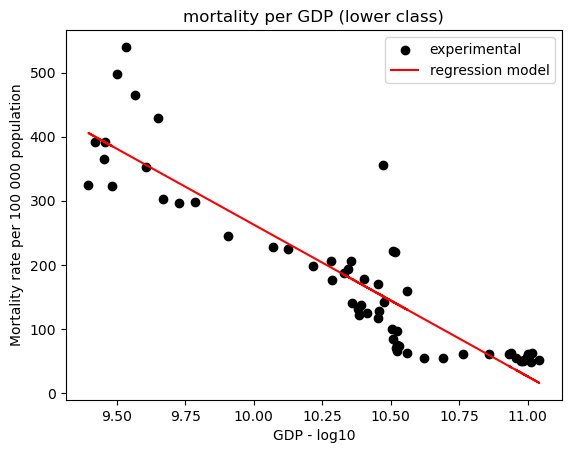

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     254.1
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           7.33e-23
Time:                        01:19:24   Log-Likelihood:                -326.45
No. Observations:                  60   AIC:                             656.9
Df Residuals:                      58   BIC:                             661.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2630.6009    153.990     17.083      0.000    2322.357    2938.845
x1          -236.7824     14.853    -15.941      0.000    -266.515    -207.050
==============================================================================
Omnibus:                       22.107   Durbin-Watson:                   0.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.056
Skew:                           1.344   Prob(JB):                     6.64e-08
Kurtosis:                       5.449   Cond. No.                         220.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [142]:
# plot regression line and scatter for lower class
regression_plot_information(lowerClassGdpDf, 'lower class')

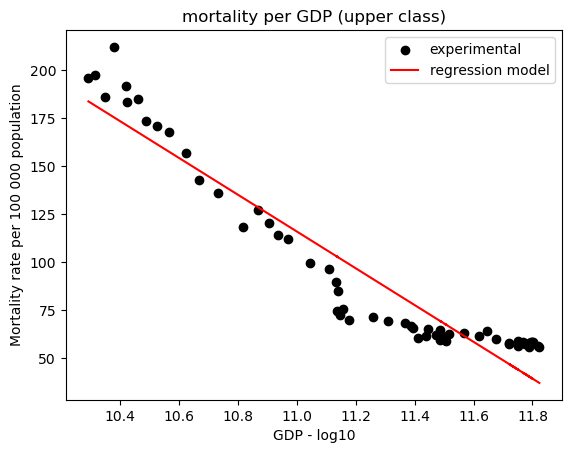

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     553.3
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           2.38e-31
Time:                        01:19:25   Log-Likelihood:                -246.60
No. Observations:                  60   AIC:                             497.2
Df Residuals:                      58   BIC:                             501.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1170.7082     45.815     25.553      0.000    1078.999    1262.417
x1           -95.8711      4.076    -23.523      0.000    -104.029     -87.713
==============================================================================
Omnibus:                        1.990   Durbin-Watson:                   0.180
Prob(Omnibus):                  0.370   Jarque-Bera (JB):                1.306
Skew:                          -0.001   Prob(JB):                        0.521
Kurtosis:                       2.277   Cond. No.                         268.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [143]:
# plot regression line and scatter for upper class
regression_plot_information(upperClassGdpDf, 'upper class')

the scatter plots and regrresion lines show a declining relationship between Mortality and GDP. It means that by increasing GDP, Moratality rate decreases. p-value is very low (although it is probably not exactly 0).This means that there is a strong correlation between GDP and mortality rate. Indeed, countries with higher rate of GDP are wealthier, so they invest more buget on health system. consequently, the mortality rate can decrease derastically.

Next, the alternative hypothesis mentioned above will be investigated. to achieve this aim, first the normality of the data sets will be investigated by sketching histogram and Q-Q plot.

In [144]:
# Preparing data
lowerMortalityDf,upperMortalityDf = making_mean_df_mortality('Year', sex='All',
                        age='Age_all', mortalityPar='Death rate per 100 000 population')

Estimation method: robust
mu = 138.8, sigma = 125.1


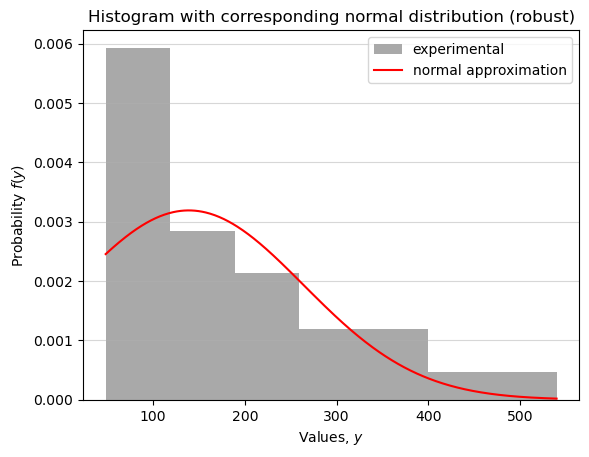

In [145]:
DS_Q_Q_Hist(lowerMortalityDf['mean'].loc['1960':'2019'])

Estimation method: robust
n = 60, mu = 138.8, sigma = 125.1
Expected number of data outside CI: 3


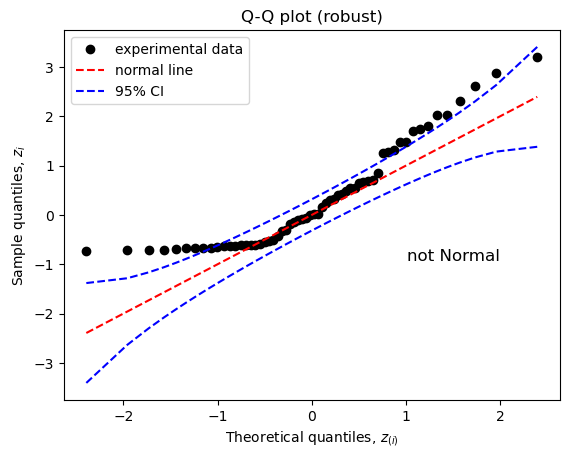

In [146]:
DS_Q_Q_Plot(lowerMortalityDf['mean'].loc['1960':'2019'])

The lower class mean value mortality data from 1960 to 2021 is not distributed normally. It seems that this dataset is distributed with a Gamma pattern

Estimation method: robust
mu = 66.5, sigma = 44.07


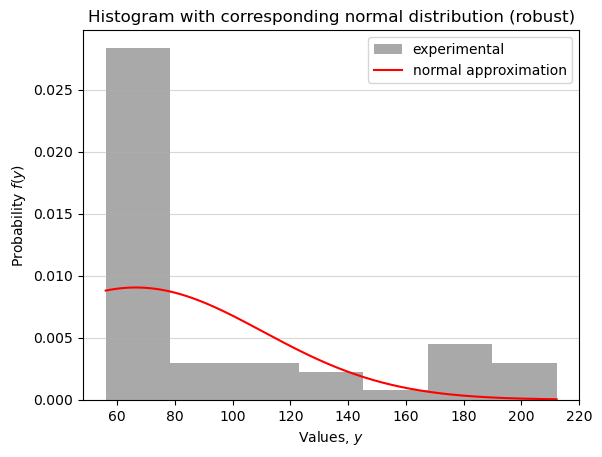

In [147]:
DS_Q_Q_Hist(upperMortalityDf['mean'].loc['1960':'2019'])

Estimation method: robust
n = 60, mu = 66.5, sigma = 44.07
Expected number of data outside CI: 3


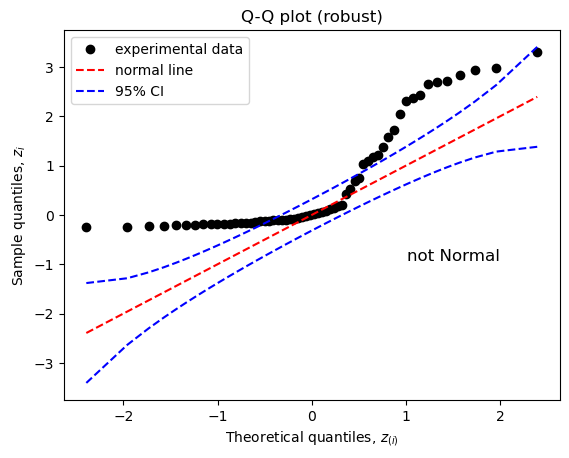

In [148]:
DS_Q_Q_Plot(upperMortalityDf['mean'].loc['1960':'2019'])

The upper class mean value mortality data from 1960 to 2021 is not distributed normally. It seems that this dataset is distributed with a specific type Gamma pattern. Conequently, due to the shape of distributions, the best statistical test to investigate the alternative hypothesis that one can use here is Wilcoxon test.

In [149]:
wilcoxonTest = wilcoxon_test(upperMortalityDf['mean'].loc['1960':'2019'], lowerMortalityDf['mean'].loc['1960':'2019'], 'greater')
print(f'p value is {wilcoxonTest[1]}')

p value is 2.1198498235597423e-09


So, the p value is almost zero that means that the alternative hypothesis is approved and the mortality in lower class countries are in general more than upper class countries.

In conclusion, both hypotheses are approved as a quite strong relationship between economic factor (GDP) and mortality rate have been found. Also, it is found that the mortality rate is higher in lower class countries.